In [1]:
# расскоментируйте код ниже, чтобы установить все зависимости
# !pip install -q \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     pandas==2.0.3 \
#     lightfm==1.17 \
#     optuna==3.3.0 \
#     tqdm==4.65.0 \
#     scipy==1.10.1 \
#     numpy==1.24.3 \
#     faiss-cpu==1.7.4 \
#     implicit==0.7.0

In [1]:
# раскоментируйте код ниже, чтобы скачать данные
# !wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip -q ml-1m.zip

replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
import optuna
import random

import polars as pl
import pandas as pd
import numpy as np

from typing import List
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

import implicit
import faiss
from lightfm import LightFM

/home/i.nurgaliev/recsys/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Как и раньше, будем работать с датаестом movielens, где есть информация об явной реакции для фильмов и сериалов

In [3]:
ratings = pd.read_csv(
    'ml-1m/ratings.dat', delimiter='::', header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'], 
    engine='python'
)
ratings = pl.from_pandas(ratings).filter(pl.col('rating') >= 4)
ratings

user_id,item_id,rating,timestamp
i64,i64,i64,i64
1,1193,5,978300760
1,3408,4,978300275
1,2355,5,978824291
1,1287,5,978302039
1,2804,5,978300719
1,594,4,978302268
1,919,4,978301368
1,595,5,978824268
1,938,4,978301752


In [4]:
grouped_df = (
    ratings
    .groupby('user_id')
    .agg([
        pl.col('item_id').apply(lambda x: x[:-3]).alias('train_item_ids'),
        pl.col('rating').apply(lambda x: x[:-3]).alias('train_ratings'),
        pl.col('item_id').apply(lambda x: x[-3:]).alias('test_item_ids'),
        pl.col('rating').apply(lambda x: x[-3:]).alias('test_ratings'),
    ])
)
grouped_df

user_id,train_item_ids,train_ratings,test_item_ids,test_ratings
i64,list[i64],list[i64],list[i64],list[i64]
688,"[1250, 1262, … 1224]","[4, 4, … 4]","[2028, 1233, 1242]","[4, 5, 4]"
3280,"[1249, 1250, … 1090]","[4, 4, … 4]","[1240, 1246, 1247]","[4, 5, 5]"
4848,"[589, 3005, … 2762]","[4, 4, … 5]","[527, 2013, 2028]","[5, 5, 5]"
2016,"[2987, 2989, … 2040]","[5, 5, … 4]","[1240, 2985, 3788]","[4, 4, 4]"
4992,"[593, 3429, … 2739]","[4, 5, … 4]","[1073, 541, 1077]","[4, 5, 4]"
2384,"[586, 588, … 377]","[4, 4, … 5]","[3751, 1225, 2046]","[4, 5, 4]"
2256,"[1259, 589, … 2000]","[5, 4, … 5]","[2006, 1079, 2028]","[5, 5, 5]"
2576,"[589, 3000, … 1240]","[5, 4, … 4]","[1242, 2046, 2985]","[4, 4, 4]"
5984,"[3471, 260, … 2706]","[5, 5, … 4]","[541, 1077, 1097]","[5, 5, 4]"


In [5]:
median_seq_len = int(grouped_df['train_item_ids'].apply(len).median())
print(f"средняя длина сессии {median_seq_len}")

средняя длина сессии 55


In [6]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, train_item_ids, train_ratings in grouped_df.select(
    'user_id', 'train_item_ids', 'train_ratings'
).rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend(train_ratings)

user_item_data = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)
user_item_data

<6041x3953 sparse matrix of type '<class 'numpy.float32'>'
	with 557171 stored elements in Compressed Sparse Row format>

In [7]:
TOP_K = 10


def user_hitrate(y_relevant: List[str], y_recs: List[str], k: int = TOP_K) -> int:
    return int(len(set(y_relevant).intersection(y_recs[:k])) > 0)

In [8]:
RANDOM_STATE = 42

def set_seed():
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)
    
    
def get_recommendations(user_embs: np.array, item_embs: np.array, k: int = TOP_K):
    # строим индекс объектов
    index = faiss.IndexFlatIP(item_embs.shape[1])
    index.add(item_embs)

    # строим рекомендации с помощью dot-product расстояния
    return index.search(user_embs, k)

def evaluate_model(user_embs: np.array, item_embs: np.array):
    # строим рекомендации с запасом, так как включена фильтрация уже просмотренного
    # и может не остаться рекомендаций после нее
    _, recs = get_recommendations(user_embs, item_embs, TOP_K + median_seq_len)
    
    # посчитаем метрики качества рекомендаций
    hitrate_list = []
    for user_id, user_history, y_rel in grouped_df.select('user_id', 'train_item_ids', 'test_item_ids').rows():
        y_rec = [
            item_id
            for item_id in recs[user_id]
            # фильтруем уже просмотренное
            if item_id not in user_history
        ]
        hitrate_list.append(user_hitrate(y_rel, y_rec))
    return np.mean(hitrate_list)

## SVD

У такого алгоритма есть параметр `k` – количество главных компонент, которые можно интерпретировать как размерность скрытого пространства модели

Попробуем провести эксперимент с зависимостью от того, как хорошо алгоритм SVD восстанавливает матрицу рейтингов и качеством самих рекомендаций. Для этого будем использовать реализацию SVD алгоритма из библиотеки [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html)

100%|████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:43<00:00,  2.15s/it]

Оптимальное k = 56 (Hitrate@10 = 0.234)


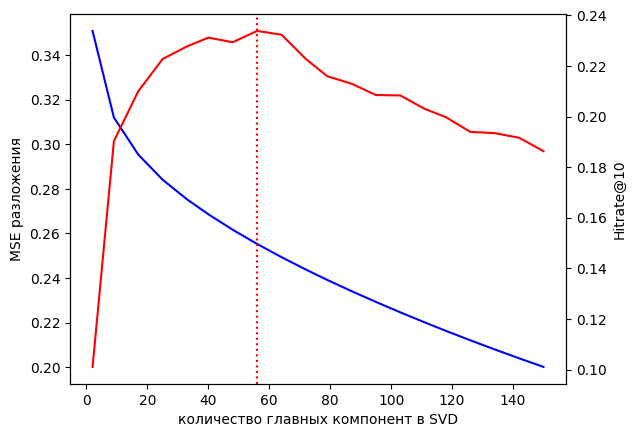

In [9]:
k_range = []
mse_list = []
mean_hitrate_list = []

for k in tqdm(np.linspace(2, 150, 20)):
    k = int(k)
    k_range.append(k)
    
    # выполним алгоритм SVD с заданным числом главных компонент k
    U, S, V = sp.linalg.svds(user_item_data, k=k, random_state=RANDOM_STATE)
    
    # посчитаем ошибку MSE восстановленной матрицы с помощью SVD разложения
    mse = np.power(U @ np.diag(S) @ V - user_item_data, 2).mean()
    mse_list.append(mse)

    # построим рекомендации с помощью cosine knn index
    user_embs, item_embs = U @ np.diag(S), V.T
    mean_hitrate = evaluate_model(
        user_embs,
        item_embs,
    )
    mean_hitrate_list.append(mean_hitrate)
    
k_optimal = k_range[np.argmax(mean_hitrate_list)]
print(f'Оптимальное k = {k_optimal} (Hitrate@{TOP_K} = {np.max(mean_hitrate_list):.3f})')

fig, ax1 = plt.subplots()
ax1.plot(k_range, mse_list, c='b')
ax1.set_xlabel('количество главных компонент в SVD')
ax1.set_ylabel('MSE разложения')

ax2 = ax1.twinx()

ax2.plot(k_range, mean_hitrate_list, c='r')
ax2.set_ylabel(f'Hitrate@{TOP_K}')
ax2.axvline(x=k_optimal, c='r', linestyle=':')
plt.show()

## ALS, BPR (из библиотеки implicit)

Гиперпараметры могут сильно влиять на метрики качества, поэтому стоит их подобрать с помощью библиотеки [optuna](https://optuna.org/)

Для алгоритма [ALS](https://benfred.github.io/implicit/api/models/cpu/als.html) рассмотрим следующие параметры:
- `factors` – размерность эмбеддингов
- `iterations` – сколько итераций будет обучаться алгоритм
- `alpha` – параметр implicitALS, учитывающий оценку в разреженной матрице как вес
- `regularization` – параметр регуляризации эмбеддингов

In [20]:
set_seed()
als_model = implicit.als.AlternatingLeastSquares(
    factors=64,
    iterations=30,
    calculate_training_loss=True,
    random_state=RANDOM_STATE,
    regularization=0.05
)
als_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    als_model.user_factors.to_numpy(),
    als_model.item_factors.to_numpy(),
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

100%|███████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.90it/s, loss=0.0313]


Hitrate@10 = 0.20934084133819145


In [22]:
def objective(trial):
    factors = trial.suggest_int('factors', 8, 128)
    iterations = trial.suggest_int('iterations', 5, 30)
    alpha = trial.suggest_float('alpha', 0.1, 5.0)
    regularization = trial.suggest_float('regularization', 1e-3, 1.0)
        
    print({
        'factors': factors,
        'iterations': iterations,
        'alpha': alpha,
        'regularization': regularization,
    })
    
    set_seed()
    als_model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        iterations=iterations,
        random_state=RANDOM_STATE,
        alpha=alpha,
        regularization=regularization
    )
    als_model.fit(user_item_data)
    
    mean_hitrate = evaluate_model(
        als_model.user_factors.to_numpy(),
        als_model.item_factors.to_numpy(),
    )
    
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    
# для запуска optuna нужно определить функцию и направление (минимизация/максимизация)
# в данном случае мы максимизируем метрику Hitrate@10
study = optuna.create_study(directions=('maximize',))
# запустим процесс подбора гиперпараметров
study.optimize(objective, n_trials=25)

# лучшие параметры будут храниться тут
study.best_params

[I 2023-10-15 22:22:40,777] A new study created in memory with name: no-name-c300bee2-e241-4727-89e6-f795be505121


{'factors': 42, 'iterations': 17, 'alpha': 0.25736027721725935, 'regularization': 0.9116236163146205}


100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 59.68it/s]
[I 2023-10-15 22:22:42,394] Trial 0 finished with value: 0.20652533951639615 and parameters: {'factors': 42, 'iterations': 17, 'alpha': 0.25736027721725935, 'regularization': 0.9116236163146205}. Best is trial 0 with value: 0.20652533951639615.


Hitrate@10 = 0.20652533951639615
{'factors': 36, 'iterations': 9, 'alpha': 4.300252602980881, 'regularization': 0.11905414972967018}


100%|██████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 93.06it/s]
[I 2023-10-15 22:22:43,621] Trial 1 finished with value: 0.19824445180523353 and parameters: {'factors': 36, 'iterations': 9, 'alpha': 4.300252602980881, 'regularization': 0.11905414972967018}. Best is trial 0 with value: 0.20652533951639615.


Hitrate@10 = 0.19824445180523353
{'factors': 67, 'iterations': 14, 'alpha': 0.6137144924613347, 'regularization': 0.7106606926884209}


100%|████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 57.86it/s]
[I 2023-10-15 22:22:44,984] Trial 2 finished with value: 0.2073534282875124 and parameters: {'factors': 67, 'iterations': 14, 'alpha': 0.6137144924613347, 'regularization': 0.7106606926884209}. Best is trial 2 with value: 0.2073534282875124.


Hitrate@10 = 0.2073534282875124
{'factors': 75, 'iterations': 25, 'alpha': 2.7113909089590416, 'regularization': 0.7979811800917859}


100%|████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 88.99it/s]
[I 2023-10-15 22:22:46,379] Trial 3 finished with value: 0.21248757866843326 and parameters: {'factors': 75, 'iterations': 25, 'alpha': 2.7113909089590416, 'regularization': 0.7979811800917859}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.21248757866843326
{'factors': 84, 'iterations': 13, 'alpha': 4.532419489189685, 'regularization': 0.14175972632784775}


100%|████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 88.86it/s]
[I 2023-10-15 22:22:47,649] Trial 4 finished with value: 0.21066578337197747 and parameters: {'factors': 84, 'iterations': 13, 'alpha': 4.532419489189685, 'regularization': 0.14175972632784775}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.21066578337197747
{'factors': 58, 'iterations': 20, 'alpha': 1.8251622182565022, 'regularization': 0.558684997357288}


100%|████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 93.99it/s]
[I 2023-10-15 22:22:48,988] Trial 5 finished with value: 0.20718781053328916 and parameters: {'factors': 58, 'iterations': 20, 'alpha': 1.8251622182565022, 'regularization': 0.558684997357288}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.20718781053328916
{'factors': 23, 'iterations': 14, 'alpha': 0.7640790489747126, 'regularization': 0.9056484910490833}


100%|███████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 143.47it/s]
[I 2023-10-15 22:22:50,239] Trial 6 finished with value: 0.19509771447499172 and parameters: {'factors': 23, 'iterations': 14, 'alpha': 0.7640790489747126, 'regularization': 0.9056484910490833}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.19509771447499172
{'factors': 124, 'iterations': 7, 'alpha': 1.228893596319254, 'regularization': 0.9604269176503792}


100%|██████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 49.37it/s]
[I 2023-10-15 22:22:51,480] Trial 7 finished with value: 0.2007287181185823 and parameters: {'factors': 124, 'iterations': 7, 'alpha': 1.228893596319254, 'regularization': 0.9604269176503792}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.2007287181185823
{'factors': 97, 'iterations': 27, 'alpha': 4.365820943399843, 'regularization': 0.9468529525085546}


100%|████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 76.33it/s]
[I 2023-10-15 22:22:52,951] Trial 8 finished with value: 0.20801589930440542 and parameters: {'factors': 97, 'iterations': 27, 'alpha': 4.365820943399843, 'regularization': 0.9468529525085546}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.20801589930440542
{'factors': 26, 'iterations': 5, 'alpha': 1.1062765912210828, 'regularization': 0.781948790449637}


100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 141.86it/s]
[I 2023-10-15 22:22:54,141] Trial 9 finished with value: 0.20089433587280556 and parameters: {'factors': 26, 'iterations': 5, 'alpha': 1.1062765912210828, 'regularization': 0.781948790449637}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.20089433587280556
{'factors': 107, 'iterations': 30, 'alpha': 2.9563967086306975, 'regularization': 0.4001681010087736}


100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.89it/s]
[I 2023-10-15 22:22:55,862] Trial 10 finished with value: 0.2028817489234846 and parameters: {'factors': 107, 'iterations': 30, 'alpha': 2.9563967086306975, 'regularization': 0.4001681010087736}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.2028817489234846
{'factors': 88, 'iterations': 23, 'alpha': 3.506385647157761, 'regularization': 0.07531778415733656}


100%|████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 88.96it/s]
[I 2023-10-15 22:22:57,242] Trial 11 finished with value: 0.20652533951639615 and parameters: {'factors': 88, 'iterations': 23, 'alpha': 3.506385647157761, 'regularization': 0.07531778415733656}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.20652533951639615
{'factors': 82, 'iterations': 23, 'alpha': 2.355524789857844, 'regularization': 0.3061695507795721}


100%|████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 89.01it/s]
[I 2023-10-15 22:22:58,614] Trial 12 finished with value: 0.2063597217621729 and parameters: {'factors': 82, 'iterations': 23, 'alpha': 2.355524789857844, 'regularization': 0.3061695507795721}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.2063597217621729
{'factors': 56, 'iterations': 13, 'alpha': 4.627248484318128, 'regularization': 0.5796199143160543}


100%|████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 94.06it/s]
[I 2023-10-15 22:22:59,871] Trial 13 finished with value: 0.20685657502484267 and parameters: {'factors': 56, 'iterations': 13, 'alpha': 4.627248484318128, 'regularization': 0.5796199143160543}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.20685657502484267
{'factors': 74, 'iterations': 19, 'alpha': 4.972092213632676, 'regularization': 0.2536298674617634}


100%|████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 88.58it/s]
[I 2023-10-15 22:23:01,221] Trial 14 finished with value: 0.20867837032129843 and parameters: {'factors': 74, 'iterations': 19, 'alpha': 4.972092213632676, 'regularization': 0.2536298674617634}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.20867837032129843
{'factors': 105, 'iterations': 11, 'alpha': 3.7073710014095527, 'regularization': 0.026282158448945353}


100%|████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 84.56it/s]
[I 2023-10-15 22:23:02,474] Trial 15 finished with value: 0.20404107320304737 and parameters: {'factors': 105, 'iterations': 11, 'alpha': 3.7073710014095527, 'regularization': 0.026282158448945353}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.20404107320304737
{'factors': 54, 'iterations': 25, 'alpha': 2.797409011916298, 'regularization': 0.46354385957997485}


100%|████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 94.34it/s]
[I 2023-10-15 22:23:03,879] Trial 16 finished with value: 0.2060284862537264 and parameters: {'factors': 54, 'iterations': 25, 'alpha': 2.797409011916298, 'regularization': 0.46354385957997485}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.2060284862537264
{'factors': 123, 'iterations': 17, 'alpha': 3.575455456357237, 'regularization': 0.18224870083112768}


100%|████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 84.10it/s]
[I 2023-10-15 22:23:05,181] Trial 17 finished with value: 0.20652533951639615 and parameters: {'factors': 123, 'iterations': 17, 'alpha': 3.575455456357237, 'regularization': 0.18224870083112768}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.20652533951639615
{'factors': 86, 'iterations': 29, 'alpha': 2.031343593233255, 'regularization': 0.34921815594724004}


100%|████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 88.87it/s]
[I 2023-10-15 22:23:06,618] Trial 18 finished with value: 0.210997018880424 and parameters: {'factors': 86, 'iterations': 29, 'alpha': 2.031343593233255, 'regularization': 0.34921815594724004}. Best is trial 3 with value: 0.21248757866843326.


Hitrate@10 = 0.210997018880424
{'factors': 71, 'iterations': 30, 'alpha': 2.1833587760214033, 'regularization': 0.37975730556309517}


100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.50it/s]
[I 2023-10-15 22:23:08,088] Trial 19 finished with value: 0.21464060947333555 and parameters: {'factors': 71, 'iterations': 30, 'alpha': 2.1833587760214033, 'regularization': 0.37975730556309517}. Best is trial 19 with value: 0.21464060947333555.


Hitrate@10 = 0.21464060947333555
{'factors': 71, 'iterations': 27, 'alpha': 1.7199056587381638, 'regularization': 0.4667221526435446}


100%|████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 89.01it/s]
[I 2023-10-15 22:23:09,689] Trial 20 finished with value: 0.21248757866843326 and parameters: {'factors': 71, 'iterations': 27, 'alpha': 1.7199056587381638, 'regularization': 0.4667221526435446}. Best is trial 19 with value: 0.21464060947333555.


Hitrate@10 = 0.21248757866843326
{'factors': 65, 'iterations': 27, 'alpha': 1.7015792815880695, 'regularization': 0.5113380251795362}


100%|████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 89.77it/s]
[I 2023-10-15 22:23:11,148] Trial 21 finished with value: 0.20437230871149387 and parameters: {'factors': 65, 'iterations': 27, 'alpha': 1.7015792815880695, 'regularization': 0.5113380251795362}. Best is trial 19 with value: 0.21464060947333555.


Hitrate@10 = 0.20437230871149387
{'factors': 45, 'iterations': 27, 'alpha': 2.3295931235207306, 'regularization': 0.4618654576668131}


100%|████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 94.79it/s]
[I 2023-10-15 22:23:12,606] Trial 22 finished with value: 0.2045379264657171 and parameters: {'factors': 45, 'iterations': 27, 'alpha': 2.3295931235207306, 'regularization': 0.4618654576668131}. Best is trial 19 with value: 0.21464060947333555.


Hitrate@10 = 0.2045379264657171
{'factors': 75, 'iterations': 23, 'alpha': 1.597241745804807, 'regularization': 0.6337481074298371}


100%|████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 89.19it/s]
[I 2023-10-15 22:23:14,013] Trial 23 finished with value: 0.21315004968532628 and parameters: {'factors': 75, 'iterations': 23, 'alpha': 1.597241745804807, 'regularization': 0.6337481074298371}. Best is trial 19 with value: 0.21464060947333555.


Hitrate@10 = 0.21315004968532628
{'factors': 96, 'iterations': 23, 'alpha': 2.603226322524504, 'regularization': 0.647830920005801}


100%|████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 89.26it/s]
[I 2023-10-15 22:23:15,401] Trial 24 finished with value: 0.2053660152368334 and parameters: {'factors': 96, 'iterations': 23, 'alpha': 2.603226322524504, 'regularization': 0.647830920005801}. Best is trial 19 with value: 0.21464060947333555.


Hitrate@10 = 0.2053660152368334


{'factors': 71,
 'iterations': 30,
 'alpha': 2.1833587760214033,
 'regularization': 0.37975730556309517}

In [23]:
als_model = implicit.als.AlternatingLeastSquares(
    random_state=RANDOM_STATE,
    **study.best_params
)
als_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    als_model.user_factors.to_numpy(),
    als_model.item_factors.to_numpy(),
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.85it/s]


Hitrate@10 = 0.21464060947333555


Дла алгоритма [BPR](https://benfred.github.io/implicit/api/models/cpu/bpr.html) рассмотрим следующие параметры:

- `factors` – размерность эмбеддингов
- `iterations` – сколько итераций будет обучаться алгоритм
- `learning_rate` – скорость обучения алгоритма градиентного спуска
- `regularization` – параметр регуляризации эмбеддингов

In [24]:
def objective(trial):
    factors = trial.suggest_int('factors', 8, 128)
    iterations = trial.suggest_int('iterations', 10, 100)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    regularization = trial.suggest_float('regularization', 1e-3, 1e-1)
        
    print({
        'factors': factors,
        'iterations': iterations,
        'learning_rate': learning_rate,
        'regularization': regularization,
    })
    
    set_seed()
    bpr_model = implicit.bpr.BayesianPersonalizedRanking(
        factors=factors,
        iterations=iterations,
        random_state=RANDOM_STATE,
        learning_rate=learning_rate,
        regularization=regularization
    )
    bpr_model.fit(user_item_data)
    
    mean_hitrate = evaluate_model(
        bpr_model.user_factors.to_numpy(),
        bpr_model.item_factors.to_numpy(),
    )
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    
    
study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=25)

study.best_params

[I 2023-10-15 22:25:22,947] A new study created in memory with name: no-name-9a37d70a-d8a7-4d79-ab17-d78acb230942


{'factors': 74, 'iterations': 46, 'learning_rate': 0.06940347478220357, 'regularization': 0.03144185482811491}


100%|█████████████████████████████████████████████████████| 46/46 [00:00<00:00, 276.38it/s, train_auc=86.62%, skipped=20.88%]
[I 2023-10-15 22:25:24,423] Trial 0 finished with value: 0.1447499171911229 and parameters: {'factors': 74, 'iterations': 46, 'learning_rate': 0.06940347478220357, 'regularization': 0.03144185482811491}. Best is trial 0 with value: 0.1447499171911229.


Hitrate@10 = 0.1447499171911229
{'factors': 20, 'iterations': 68, 'learning_rate': 0.011677901388630845, 'regularization': 0.09626067021099809}


100%|█████████████████████████████████████████████████████| 68/68 [00:00<00:00, 620.46it/s, train_auc=74.72%, skipped=20.97%]
[I 2023-10-15 22:25:25,936] Trial 1 finished with value: 0.07138125207022193 and parameters: {'factors': 20, 'iterations': 68, 'learning_rate': 0.011677901388630845, 'regularization': 0.09626067021099809}. Best is trial 0 with value: 0.1447499171911229.


Hitrate@10 = 0.07138125207022193
{'factors': 29, 'iterations': 57, 'learning_rate': 0.09563869310514955, 'regularization': 0.04937627866169859}


100%|█████████████████████████████████████████████████████| 57/57 [00:00<00:00, 453.87it/s, train_auc=83.22%, skipped=20.91%]
[I 2023-10-15 22:25:27,397] Trial 2 finished with value: 0.1152699569393839 and parameters: {'factors': 29, 'iterations': 57, 'learning_rate': 0.09563869310514955, 'regularization': 0.04937627866169859}. Best is trial 0 with value: 0.1447499171911229.


Hitrate@10 = 0.1152699569393839
{'factors': 66, 'iterations': 78, 'learning_rate': 0.07731937391971844, 'regularization': 0.027519401831365104}


100%|█████████████████████████████████████████████████████| 78/78 [00:00<00:00, 363.17it/s, train_auc=88.32%, skipped=20.91%]
[I 2023-10-15 22:25:28,851] Trial 3 finished with value: 0.1531964226565088 and parameters: {'factors': 66, 'iterations': 78, 'learning_rate': 0.07731937391971844, 'regularization': 0.027519401831365104}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.1531964226565088
{'factors': 100, 'iterations': 56, 'learning_rate': 0.023776766317865957, 'regularization': 0.08276229590241356}


100%|█████████████████████████████████████████████████████| 56/56 [00:00<00:00, 355.04it/s, train_auc=80.09%, skipped=20.89%]
[I 2023-10-15 22:25:30,561] Trial 4 finished with value: 0.09937065253395164 and parameters: {'factors': 100, 'iterations': 56, 'learning_rate': 0.023776766317865957, 'regularization': 0.08276229590241356}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.09937065253395164
{'factors': 70, 'iterations': 73, 'learning_rate': 0.015169424885531977, 'regularization': 0.09172612128640337}


100%|█████████████████████████████████████████████████████| 73/73 [00:00<00:00, 306.07it/s, train_auc=77.23%, skipped=20.90%]
[I 2023-10-15 22:25:32,207] Trial 5 finished with value: 0.09125538257701225 and parameters: {'factors': 70, 'iterations': 73, 'learning_rate': 0.015169424885531977, 'regularization': 0.09172612128640337}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.09125538257701225
{'factors': 69, 'iterations': 69, 'learning_rate': 0.02515437447668428, 'regularization': 0.08146663002020792}


100%|█████████████████████████████████████████████████████| 69/69 [00:00<00:00, 435.85it/s, train_auc=80.61%, skipped=20.92%]
[I 2023-10-15 22:25:33,755] Trial 6 finished with value: 0.10914210003312355 and parameters: {'factors': 69, 'iterations': 69, 'learning_rate': 0.02515437447668428, 'regularization': 0.08146663002020792}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.10914210003312355
{'factors': 103, 'iterations': 39, 'learning_rate': 0.03614358241749581, 'regularization': 0.05351710599868702}


100%|█████████████████████████████████████████████████████| 39/39 [00:00<00:00, 364.97it/s, train_auc=82.44%, skipped=20.91%]
[I 2023-10-15 22:25:35,229] Trial 7 finished with value: 0.11543557469360716 and parameters: {'factors': 103, 'iterations': 39, 'learning_rate': 0.03614358241749581, 'regularization': 0.05351710599868702}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.11543557469360716
{'factors': 108, 'iterations': 38, 'learning_rate': 0.009957467786747855, 'regularization': 0.057870216332725384}


100%|█████████████████████████████████████████████████████| 38/38 [00:00<00:00, 239.78it/s, train_auc=73.67%, skipped=20.93%]
[I 2023-10-15 22:25:36,804] Trial 8 finished with value: 0.08115269956939383 and parameters: {'factors': 108, 'iterations': 38, 'learning_rate': 0.009957467786747855, 'regularization': 0.057870216332725384}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.08115269956939383
{'factors': 117, 'iterations': 33, 'learning_rate': 0.06524008585525246, 'regularization': 0.09328868539380082}


100%|█████████████████████████████████████████████████████| 33/33 [00:00<00:00, 342.02it/s, train_auc=79.15%, skipped=20.87%]
[I 2023-10-15 22:25:38,344] Trial 9 finished with value: 0.07403113613779397 and parameters: {'factors': 117, 'iterations': 33, 'learning_rate': 0.06524008585525246, 'regularization': 0.09328868539380082}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.07403113613779397
{'factors': 42, 'iterations': 98, 'learning_rate': 0.09781150957511991, 'regularization': 0.0013245228488918126}


100%|█████████████████████████████████████████████████████| 98/98 [00:00<00:00, 367.05it/s, train_auc=88.17%, skipped=20.98%]
[I 2023-10-15 22:25:39,887] Trial 10 finished with value: 0.10847962901623054 and parameters: {'factors': 42, 'iterations': 98, 'learning_rate': 0.09781150957511991, 'regularization': 0.0013245228488918126}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.10847962901623054
{'factors': 53, 'iterations': 13, 'learning_rate': 0.06831912651890985, 'regularization': 0.02186002221987841}


100%|█████████████████████████████████████████████████████| 13/13 [00:00<00:00, 522.30it/s, train_auc=83.56%, skipped=20.93%]
[I 2023-10-15 22:25:41,216] Trial 11 finished with value: 0.13696588274263 and parameters: {'factors': 53, 'iterations': 13, 'learning_rate': 0.06831912651890985, 'regularization': 0.02186002221987841}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.13696588274263
{'factors': 84, 'iterations': 93, 'learning_rate': 0.07034826260174296, 'regularization': 0.030074494085875234}


100%|█████████████████████████████████████████████████████| 93/93 [00:00<00:00, 327.43it/s, train_auc=87.88%, skipped=20.86%]
[I 2023-10-15 22:25:42,793] Trial 12 finished with value: 0.14210003312355085 and parameters: {'factors': 84, 'iterations': 93, 'learning_rate': 0.07034826260174296, 'regularization': 0.030074494085875234}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.14210003312355085
{'factors': 85, 'iterations': 84, 'learning_rate': 0.053799458392814525, 'regularization': 0.03162200102838885}


100%|█████████████████████████████████████████████████████| 84/84 [00:00<00:00, 432.93it/s, train_auc=87.39%, skipped=20.95%]
[I 2023-10-15 22:25:44,459] Trial 13 finished with value: 0.134978469691951 and parameters: {'factors': 85, 'iterations': 84, 'learning_rate': 0.053799458392814525, 'regularization': 0.03162200102838885}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.134978469691951
{'factors': 53, 'iterations': 22, 'learning_rate': 0.08431431059372158, 'regularization': 0.014901468034508692}


100%|█████████████████████████████████████████████████████| 22/22 [00:00<00:00, 530.89it/s, train_auc=88.57%, skipped=20.89%]
[I 2023-10-15 22:25:45,773] Trial 14 finished with value: 0.14657171248757866 and parameters: {'factors': 53, 'iterations': 22, 'learning_rate': 0.08431431059372158, 'regularization': 0.014901468034508692}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.14657171248757866
{'factors': 48, 'iterations': 15, 'learning_rate': 0.08746977953636832, 'regularization': 0.005621939064283429}


100%|█████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.90it/s, train_auc=88.14%, skipped=20.93%]
[I 2023-10-15 22:25:47,064] Trial 15 finished with value: 0.14590924147068565 and parameters: {'factors': 48, 'iterations': 15, 'learning_rate': 0.08746977953636832, 'regularization': 0.005621939064283429}. Best is trial 3 with value: 0.1531964226565088.


Hitrate@10 = 0.14590924147068565
{'factors': 56, 'iterations': 27, 'learning_rate': 0.08673399784685237, 'regularization': 0.016618062012827}


100%|█████████████████████████████████████████████████████| 27/27 [00:00<00:00, 353.84it/s, train_auc=89.01%, skipped=20.94%]
[I 2023-10-15 22:25:48,400] Trial 16 finished with value: 0.16346472341835044 and parameters: {'factors': 56, 'iterations': 27, 'learning_rate': 0.08673399784685237, 'regularization': 0.016618062012827}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.16346472341835044
{'factors': 10, 'iterations': 83, 'learning_rate': 0.08175502979651926, 'regularization': 0.015959172395422737}


100%|█████████████████████████████████████████████████████| 83/83 [00:00<00:00, 456.37it/s, train_auc=83.62%, skipped=20.92%]
[I 2023-10-15 22:25:49,915] Trial 17 finished with value: 0.11377939715137463 and parameters: {'factors': 10, 'iterations': 83, 'learning_rate': 0.08175502979651926, 'regularization': 0.015959172395422737}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.11377939715137463
{'factors': 36, 'iterations': 25, 'learning_rate': 0.05096965240775792, 'regularization': 0.03964417065513195}


100%|█████████████████████████████████████████████████████| 25/25 [00:00<00:00, 418.69it/s, train_auc=83.25%, skipped=20.92%]
[I 2023-10-15 22:25:51,291] Trial 18 finished with value: 0.1341503809208347 and parameters: {'factors': 36, 'iterations': 25, 'learning_rate': 0.05096965240775792, 'regularization': 0.03964417065513195}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.1341503809208347
{'factors': 85, 'iterations': 48, 'learning_rate': 0.07735674869967082, 'regularization': 0.010031183365515159}


100%|█████████████████████████████████████████████████████| 48/48 [00:00<00:00, 278.16it/s, train_auc=92.98%, skipped=20.95%]
[I 2023-10-15 22:25:52,664] Trial 19 finished with value: 0.13895329579330903 and parameters: {'factors': 85, 'iterations': 48, 'learning_rate': 0.07735674869967082, 'regularization': 0.010031183365515159}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.13895329579330903
{'factors': 59, 'iterations': 79, 'learning_rate': 0.09267423653090921, 'regularization': 0.019982965043313313}


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 524.13it/s, train_auc=89.59%, skipped=20.88%]
[I 2023-10-15 22:25:54,066] Trial 20 finished with value: 0.14739980125869492 and parameters: {'factors': 59, 'iterations': 79, 'learning_rate': 0.09267423653090921, 'regularization': 0.019982965043313313}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.14739980125869492
{'factors': 59, 'iterations': 79, 'learning_rate': 0.09962525733524247, 'regularization': 0.021742698239576988}


100%|█████████████████████████████████████████████████████| 79/79 [00:00<00:00, 524.61it/s, train_auc=89.07%, skipped=20.88%]
[I 2023-10-15 22:25:55,480] Trial 21 finished with value: 0.14441868168267638 and parameters: {'factors': 59, 'iterations': 79, 'learning_rate': 0.09962525733524247, 'regularization': 0.021742698239576988}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.14441868168267638
{'factors': 61, 'iterations': 91, 'learning_rate': 0.0904372413611354, 'regularization': 0.010107802461068856}


100%|█████████████████████████████████████████████████████| 91/91 [00:00<00:00, 529.04it/s, train_auc=91.06%, skipped=20.99%]
[I 2023-10-15 22:25:57,062] Trial 22 finished with value: 0.12984431931103013 and parameters: {'factors': 61, 'iterations': 91, 'learning_rate': 0.0904372413611354, 'regularization': 0.010107802461068856}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.12984431931103013
{'factors': 36, 'iterations': 62, 'learning_rate': 0.07957737090108917, 'regularization': 0.021242808171924813}


100%|█████████████████████████████████████████████████████| 62/62 [00:00<00:00, 526.95it/s, train_auc=88.26%, skipped=20.99%]
[I 2023-10-15 22:25:58,431] Trial 23 finished with value: 0.13895329579330903 and parameters: {'factors': 36, 'iterations': 62, 'learning_rate': 0.07957737090108917, 'regularization': 0.021242808171924813}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.13895329579330903
{'factors': 78, 'iterations': 76, 'learning_rate': 0.090295757792622, 'regularization': 0.003118066272712997}


100%|█████████████████████████████████████████████████████| 76/76 [00:00<00:00, 277.58it/s, train_auc=92.07%, skipped=20.89%]
[I 2023-10-15 22:25:59,945] Trial 24 finished with value: 0.12023848956608148 and parameters: {'factors': 78, 'iterations': 76, 'learning_rate': 0.090295757792622, 'regularization': 0.003118066272712997}. Best is trial 16 with value: 0.16346472341835044.


Hitrate@10 = 0.12023848956608148


{'factors': 56,
 'iterations': 27,
 'learning_rate': 0.08673399784685237,
 'regularization': 0.016618062012827}

In [25]:
bpr_model = implicit.bpr.BayesianPersonalizedRanking(
    random_state=RANDOM_STATE,
    **study.best_params
)
bpr_model.fit(user_item_data)

mean_hitrate = evaluate_model(
    bpr_model.user_factors.to_numpy(),
    bpr_model.item_factors.to_numpy(),
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

100%|█████████████████████████████████████████████████████| 27/27 [00:00<00:00, 529.32it/s, train_auc=89.06%, skipped=20.94%]


Hitrate@10 = 0.1541901291818483


## LightFM

Библиотека [LightFM](https://making.lyst.com/lightfm/docs/index.html) позволяет работать с разными функциями ошибки (logistic, bpr, warp)

рассмотрим следующие параметры:

- `no_components` – размерность эмбеддингов
- `epochs` – сколько итераций будет обучаться алгоритм
- `loss` – одна из поддерживаемых функций ошибки (logistic, bpr, warp)
- `alpha` – параметр регуляризации эмбеддингов (для пользователей и объектов используем одинаковый для ускорения)

In [32]:
user_item_data

<6041x3953 sparse matrix of type '<class 'numpy.float32'>'
	with 557171 stored elements in Compressed Sparse Row format>

In [33]:
def objective(trial):
    no_components = trial.suggest_int('no_components', 8, 64)
    epochs = trial.suggest_int('epochs', 5, 20)
    loss = trial.suggest_categorical('loss', ['logistic', 'bpr', 'warp', 'warp-kos'])
    alpha = trial.suggest_float('alpha', 0., 1e-3)
        
    print({
        'no_components': no_components,
        'alpha': alpha,
        'loss': loss,
    })
    
    set_seed()
    try:
        # модель может бросить исключение, если регуляризация слишком сильная
        lightfm_model = LightFM(
            no_components=no_components,
            loss=loss,
            item_alpha=alpha,
            user_alpha=alpha,
            k=TOP_K,
            random_state=RANDOM_STATE,
        )
        lightfm_model.fit(user_item_data, epochs=epochs, verbose=True)
    except:
        return None
    
    mean_hitrate = evaluate_model(
        lightfm_model.user_embeddings,
        lightfm_model.item_embeddings,
    )
    print(f'Hitrate@{TOP_K} = {mean_hitrate}')
    return mean_hitrate
    

study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=25)

study.best_params

[I 2023-10-15 22:30:28,484] A new study created in memory with name: no-name-a0dbcc59-9e5e-4756-a5d0-0cf1fd9e5baa


{'no_components': 46, 'alpha': 0.000622211876419784, 'loss': 'warp-kos'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]
[I 2023-10-15 22:30:47,474] Trial 0 finished with value: 0.03428287512421332 and parameters: {'no_components': 46, 'epochs': 10, 'loss': 'warp-kos', 'alpha': 0.000622211876419784}. Best is trial 0 with value: 0.03428287512421332.


Hitrate@10 = 0.03428287512421332
{'no_components': 27, 'alpha': 0.0004949049134557953, 'loss': 'logistic'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.76it/s]
[I 2023-10-15 22:30:53,401] Trial 1 finished with value: 0.0 and parameters: {'no_components': 27, 'epochs': 12, 'loss': 'logistic', 'alpha': 0.0004949049134557953}. Best is trial 0 with value: 0.03428287512421332.


Hitrate@10 = 0.0
{'no_components': 25, 'alpha': 0.0004254800929870377, 'loss': 'warp-kos'}


Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.06s/it]
[I 2023-10-15 22:31:00,187] Trial 2 finished with value: 0.025836369658827428 and parameters: {'no_components': 25, 'epochs': 5, 'loss': 'warp-kos', 'alpha': 0.0004254800929870377}. Best is trial 0 with value: 0.03428287512421332.


Hitrate@10 = 0.025836369658827428
{'no_components': 29, 'alpha': 0.0008271811363471399, 'loss': 'warp-kos'}


Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.19s/it]
[I 2023-10-15 22:31:11,258] Trial 3 finished with value: 0.02616760516727393 and parameters: {'no_components': 29, 'epochs': 8, 'loss': 'warp-kos', 'alpha': 0.0008271811363471399}. Best is trial 0 with value: 0.03428287512421332.


Hitrate@10 = 0.02616760516727393
{'no_components': 29, 'alpha': 0.0002221239252859496, 'loss': 'logistic'}


Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]
[I 2023-10-15 22:31:14,800] Trial 4 finished with value: 0.03428287512421332 and parameters: {'no_components': 29, 'epochs': 5, 'loss': 'logistic', 'alpha': 0.0002221239252859496}. Best is trial 0 with value: 0.03428287512421332.


Hitrate@10 = 0.03428287512421332
{'no_components': 48, 'alpha': 0.0004290444419538192, 'loss': 'warp-kos'}


Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:16<00:00,  1.81s/it]
[I 2023-10-15 22:31:32,718] Trial 5 finished with value: 0.048691619741636306 and parameters: {'no_components': 48, 'epochs': 9, 'loss': 'warp-kos', 'alpha': 0.0004290444419538192}. Best is trial 5 with value: 0.048691619741636306.


Hitrate@10 = 0.048691619741636306
{'no_components': 57, 'alpha': 0.0005961510554555067, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.26s/it]
[I 2023-10-15 22:31:47,764] Trial 6 finished with value: 0.18019211659489898 and parameters: {'no_components': 57, 'epochs': 11, 'loss': 'warp', 'alpha': 0.0005961510554555067}. Best is trial 6 with value: 0.18019211659489898.


Hitrate@10 = 0.18019211659489898
{'no_components': 38, 'alpha': 0.0003054441099343811, 'loss': 'logistic'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.11it/s]
[I 2023-10-15 22:31:54,158] Trial 7 finished with value: 0.004802914872474329 and parameters: {'no_components': 38, 'epochs': 10, 'loss': 'logistic', 'alpha': 0.0003054441099343811}. Best is trial 6 with value: 0.18019211659489898.


Hitrate@10 = 0.004802914872474329
{'no_components': 53, 'alpha': 7.400284832721116e-05, 'loss': 'logistic'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.63it/s]
[I 2023-10-15 22:32:04,708] Trial 8 finished with value: 0.05647565419012918 and parameters: {'no_components': 53, 'epochs': 15, 'loss': 'logistic', 'alpha': 7.400284832721116e-05}. Best is trial 6 with value: 0.18019211659489898.


Hitrate@10 = 0.05647565419012918
{'no_components': 55, 'alpha': 8.63061337553711e-05, 'loss': 'logistic'}


Epoch: 100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.57it/s]
[I 2023-10-15 22:32:11,092] Trial 9 finished with value: 0.044551175886054985 and parameters: {'no_components': 55, 'epochs': 8, 'loss': 'logistic', 'alpha': 8.63061337553711e-05}. Best is trial 6 with value: 0.18019211659489898.


Hitrate@10 = 0.044551175886054985
{'no_components': 64, 'alpha': 0.0009519413747629211, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]
[I 2023-10-15 22:32:39,690] Trial 10 finished with value: 0.15965551507121564 and parameters: {'no_components': 64, 'epochs': 20, 'loss': 'warp', 'alpha': 0.0009519413747629211}. Best is trial 6 with value: 0.18019211659489898.


Hitrate@10 = 0.15965551507121564
{'no_components': 63, 'alpha': 0.000988421560449771, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]
[I 2023-10-15 22:33:08,152] Trial 11 finished with value: 0.15087777409738323 and parameters: {'no_components': 63, 'epochs': 20, 'loss': 'warp', 'alpha': 0.000988421560449771}. Best is trial 6 with value: 0.18019211659489898.


Hitrate@10 = 0.15087777409738323
{'no_components': 9, 'alpha': 0.0007307120326345051, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  2.89it/s]
[I 2023-10-15 22:33:15,288] Trial 12 finished with value: 0.1560119244783041 and parameters: {'no_components': 9, 'epochs': 17, 'loss': 'warp', 'alpha': 0.0007307120326345051}. Best is trial 6 with value: 0.18019211659489898.


Hitrate@10 = 0.1560119244783041
{'no_components': 60, 'alpha': 0.0009991966711588183, 'loss': 'bpr'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.13s/it]
[I 2023-10-15 22:33:33,944] Trial 13 finished with value: 0.00016561775422325274 and parameters: {'no_components': 60, 'epochs': 15, 'loss': 'bpr', 'alpha': 0.0009991966711588183}. Best is trial 6 with value: 0.18019211659489898.


Hitrate@10 = 0.00016561775422325274
{'no_components': 63, 'alpha': 0.0006249445134443853, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:25<00:00,  1.40s/it]
[I 2023-10-15 22:34:00,371] Trial 14 finished with value: 0.19228221265319642 and parameters: {'no_components': 63, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0006249445134443853}. Best is trial 14 with value: 0.19228221265319642.


Hitrate@10 = 0.19228221265319642
{'no_components': 40, 'alpha': 0.0006069154070097384, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.08it/s]
[I 2023-10-15 22:34:13,807] Trial 15 finished with value: 0.1818482941371315 and parameters: {'no_components': 40, 'epochs': 13, 'loss': 'warp', 'alpha': 0.0006069154070097384}. Best is trial 14 with value: 0.19228221265319642.


Hitrate@10 = 0.1818482941371315
{'no_components': 14, 'alpha': 0.0006398045311741495, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.41it/s]
[I 2023-10-15 22:34:22,174] Trial 16 finished with value: 0.1695925803246108 and parameters: {'no_components': 14, 'epochs': 17, 'loss': 'warp', 'alpha': 0.0006398045311741495}. Best is trial 14 with value: 0.19228221265319642.


Hitrate@10 = 0.1695925803246108
{'no_components': 37, 'alpha': 0.0007673543129782681, 'loss': 'bpr'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.34it/s]
[I 2023-10-15 22:34:34,311] Trial 17 finished with value: 0.0009937065253395165 and parameters: {'no_components': 37, 'epochs': 14, 'loss': 'bpr', 'alpha': 0.0007673543129782681}. Best is trial 14 with value: 0.19228221265319642.


Hitrate@10 = 0.0009937065253395165
{'no_components': 44, 'alpha': 0.000510491146438497, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:17<00:00,  1.04s/it]
[I 2023-10-15 22:34:53,260] Trial 18 finished with value: 0.19211659489897318 and parameters: {'no_components': 44, 'epochs': 17, 'loss': 'warp', 'alpha': 0.000510491146438497}. Best is trial 14 with value: 0.19228221265319642.


Hitrate@10 = 0.19211659489897318
{'no_components': 47, 'alpha': 0.0005088551713005753, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:19<00:00,  1.06s/it]
[I 2023-10-15 22:35:13,633] Trial 19 finished with value: 0.19360715468698245 and parameters: {'no_components': 47, 'epochs': 18, 'loss': 'warp', 'alpha': 0.0005088551713005753}. Best is trial 19 with value: 0.19360715468698245.


Hitrate@10 = 0.19360715468698245
{'no_components': 50, 'alpha': 0.00033621521236465066, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:20<00:00,  1.12s/it]
[I 2023-10-15 22:35:34,983] Trial 20 finished with value: 0.20304736667770784 and parameters: {'no_components': 50, 'epochs': 18, 'loss': 'warp', 'alpha': 0.00033621521236465066}. Best is trial 20 with value: 0.20304736667770784.


Hitrate@10 = 0.20304736667770784
{'no_components': 52, 'alpha': 0.00031463769311661547, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:21<00:00,  1.18s/it]
[I 2023-10-15 22:35:57,381] Trial 21 finished with value: 0.20437230871149387 and parameters: {'no_components': 52, 'epochs': 18, 'loss': 'warp', 'alpha': 0.00031463769311661547}. Best is trial 21 with value: 0.20437230871149387.


Hitrate@10 = 0.20437230871149387
{'no_components': 51, 'alpha': 0.00032188869245772397, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:21<00:00,  1.15s/it]
[I 2023-10-15 22:36:20,376] Trial 22 finished with value: 0.20023186485591254 and parameters: {'no_components': 51, 'epochs': 19, 'loss': 'warp', 'alpha': 0.00032188869245772397}. Best is trial 21 with value: 0.20437230871149387.


Hitrate@10 = 0.20023186485591254
{'no_components': 50, 'alpha': 0.00028769112170600706, 'loss': 'warp'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:21<00:00,  1.13s/it]
[I 2023-10-15 22:36:43,083] Trial 23 finished with value: 0.2081815170586287 and parameters: {'no_components': 50, 'epochs': 19, 'loss': 'warp', 'alpha': 0.00028769112170600706}. Best is trial 23 with value: 0.2081815170586287.


Hitrate@10 = 0.2081815170586287
{'no_components': 42, 'alpha': 0.0002042865617794258, 'loss': 'bpr'}


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]
[I 2023-10-15 22:36:57,853] Trial 24 finished with value: 0.04388870486916197 and parameters: {'no_components': 42, 'epochs': 16, 'loss': 'bpr', 'alpha': 0.0002042865617794258}. Best is trial 23 with value: 0.2081815170586287.


Hitrate@10 = 0.04388870486916197


{'no_components': 50,
 'epochs': 19,
 'loss': 'warp',
 'alpha': 0.00028769112170600706}

In [34]:
lightfm_model = LightFM(
    no_components=45,
    loss='warp',
    item_alpha=4e-4,
    user_alpha=4e-4,
    k=TOP_K,
    random_state=RANDOM_STATE,
)
lightfm_model.fit(user_item_data, epochs=30, verbose=True)

mean_hitrate = evaluate_model(
    lightfm_model.user_embeddings,
    lightfm_model.item_embeddings,
)
print(f'Hitrate@{TOP_K} = {mean_hitrate}')

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.04s/it]


Hitrate@10 = 0.2091752235839682
